In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy

from modules import c

## TOV equation:  (diff-eq approach)
\begin{gather}
    \frac{dP}{dr} = 
    -\frac{G m}{r^2} \rho 
    \left(1 + \frac{P}{\rho c^2}\right) 
    \left(1 + \frac{4 \pi r^3 P}{m c^2}\right)
    \left(1 - \frac{2 G m}{r c^2}\right)^{-1}
\end{gather}

but we want to solve the scaled TOV equations:
\begin{gather}
    \boxed{
    \frac{dp(x)}{dx} = -\frac{1}{2} \frac{\left[\epsilon(x) + p(x))\right]\left[m(x) + 3 x^3 p(x)\right]}{x^2 \left[1 - m(x)/x\right]}
    \\
    \frac{dm(x)}{dx} = 3 x^2 \epsilon(x)
    }
\end{gather}

In [2]:
Epsilon_naught = 1.285  # GeV / fm^3

def epsilon(p_of_x, m_of_x):
    # eps_of_p = np.sqrt((p_of_x * c) ** 2 + (m_of_x * c) ** 2)
    eps_of_p = np.sqrt((p_of_x * 1) ** 2 + (m_of_x * 1) ** 2)
    
    return eps_of_p

def m(x, p_of_x):
    return 4 * np.pi * x**2 * p_of_x

In [3]:
n = 1_000

x, dx = np.linspace(0, 100, n, retstep=True)  # units? lets use meters for now  -- just kidding it's solar masses
x[0] = 1e-9  # some eps

from my scattering code:

```python

def full_radial_schrodinger_eqn(r_value, u, theta):

    return np.array([
                     u[1], 
                     ( 
                      (l * (l + 1)) / ((r_value) ** 2)  + 
                      ((2 * mass) / (hbarc ** 2) ) * (  theta[0] * np.exp(-kappa_r*r_value**2) + theta[1] * np.exp(-kappa_s*r_value**2)  )  - 
                      p2
                      ) * u[0]
                     ])
```

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-09  1.001e-01 ...  9.990e+01  1.000e+02]
        y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0


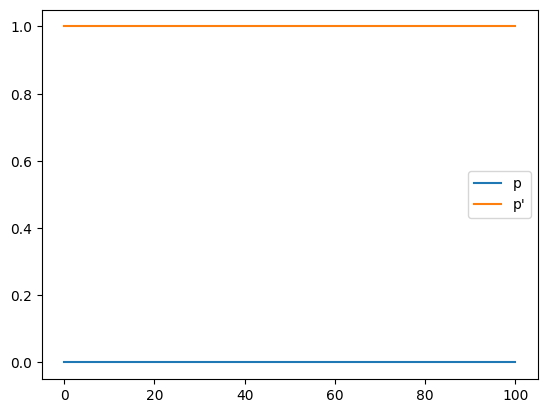

In [4]:
def solve_ivp_diffeq(x, p):
    return np.array([-0.5 * (epsilon(p[0], m(x, p[0])) + p[0]) * (m(x, p[0]) + 3 * x * p[0]) / (x**2 * (1 - m(x, p[0]) / x))])

solve_ivp_result = scipy.integrate.solve_ivp(solve_ivp_diffeq, (x[0], x[-1]), (0., 1.), t_eval=x)
print(solve_ivp_result)

p = solve_ivp_result.y[0]
p_pr = solve_ivp_result.y[1]

plt.plot(x, p, label="p")
plt.plot(x, p_pr, label="p'")
# plt.yscale("log")
plt.legend()
plt.show()

## TOV equation(s): (integral-eq approach)

\begin{gather}
    \frac{dp}{dr} = -\frac{G \rho(r) \mathcal{M}(r)}{r^2}
    \\
    \frac{d\mathcal{M}}{dr} = 4 \pi^2 \rho(r)
    \\
    \mathcal{M}(r) = 4 \pi \int_0^r r'^2 \rho(r') dr'
\end{gather}